# Fertility Rate Prediction - Feature Engineering

This notebook performs feature engineering on the cleaned dataset to create meaningful predictors for fertility rate modeling.

## Objectives:
1. Handle missing data
2. Create temporal features (lag features, rates of change)
3. Create interaction features
4. Create geographical/regional features
5. Feature selection
6. Prepare final dataset for modeling

In [89]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
import warnings

# Configure visualizations
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [90]:
# Load the cleaned dataset
df = pd.read_csv('../data/clean/final_merged_dataset_cleaned.csv')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Dataset loaded successfully!

Dataset shape: (13888, 15)

Columns: ['Country Name', 'Country Code', 'Year', 'Female share of employment in senior and middle management (%)', 'Maternal mortality ratio (per 100,000 live births)', 'Labor force participation rate, female (%)', 'advanced_education_pct', 'basic_education_pct', 'Fertility rate', 'Urban population over total population', 'Capital GDP in USD', 'Access to electricity (% of population)', 'WagedFemale', 'InfantMortality', 'LifeExpectancy']


In [91]:
# Quick overview
print("Missing data summary:")
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Pct': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Pct', ascending=False)
print(missing_summary[missing_summary['Missing_Pct'] > 0])

Missing data summary:
                                                                                               Column  \
Female share of employment in senior and middle...  Female share of employment in senior and middl...   
advanced_education_pct                                                         advanced_education_pct   
basic_education_pct                                                               basic_education_pct   
Labor force participation rate, female (%)                 Labor force participation rate, female (%)   
WagedFemale                                                                               WagedFemale   
Access to electricity (% of population)                       Access to electricity (% of population)   
Maternal mortality ratio (per 100,000 live births)  Maternal mortality ratio (per 100,000 live bir...   
InfantMortality                                                                       InfantMortality   
Capital GDP in USD               

## 2. Handle Missing Data

Strategy based on EDA findings:
- Drop features with >70% missing data
- Use forward fill for time-series features (within each country)
- Use KNN imputation for remaining features

In [92]:
# Identify columns to drop (>70% missing)
missing_pct = (df.isnull().sum() / len(df) * 100)
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()

print(f"Columns to drop (>70% missing): {cols_to_drop}")
print(f"Number of columns to drop: {len(cols_to_drop)}")

# Create working dataframe
df_work = df.drop(columns=cols_to_drop).copy()
print(f"\nNew shape after dropping high-missing columns: {df_work.shape}")

Columns to drop (>70% missing): ['Female share of employment in senior and middle management (%)', 'advanced_education_pct', 'basic_education_pct']
Number of columns to drop: 3

New shape after dropping high-missing columns: (13888, 12)


In [93]:
# Remove rows without fertility rate (our target)
df_work = df_work[df_work['Fertility rate'].notna()].copy()
print(f"Shape after removing rows without target: {df_work.shape}")

Shape after removing rows without target: (13856, 12)


In [94]:
# Sort by country and year for time-series operations
df_work = df_work.sort_values(['Country Name', 'Year']).reset_index(drop=True)
print("Data sorted by Country and Year")

Data sorted by Country and Year


In [95]:
# Apply forward fill within each country for time-series continuity
numeric_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
# Exclude Year and target from forward fill
cols_to_fill = [col for col in numeric_cols if col not in ['Year', 'Fertility rate']]

print(f"Applying forward fill within countries for {len(cols_to_fill)} features...")
df_work[cols_to_fill] = df_work.groupby('Country Name')[cols_to_fill].fillna(method='ffill')

# Check remaining missing values
print("\nMissing values after forward fill:")
missing_after_ffill = df_work[cols_to_fill].isnull().sum()
print(missing_after_ffill[missing_after_ffill > 0])

Applying forward fill within countries for 8 features...

Missing values after forward fill:
Maternal mortality ratio (per 100,000 live births)    6295
Labor force participation rate, female (%)            3075
Urban population over total population                 128
Capital GDP in USD                                    2433
Access to electricity (% of population)               7294
WagedFemale                                           8114
InfantMortality                                       3002
LifeExpectancy                                         897
dtype: int64


In [96]:
# For remaining missing values, use median imputation (simpler than KNN for now)
# We'll use median because our data has outliers
print("Applying median imputation for remaining missing values...")

for col in cols_to_fill:
    missing_count = df_work[col].isnull().sum()  # Count BEFORE filling
    if missing_count > 0:
        median_value = df_work[col].median()
        df_work[col].fillna(median_value, inplace=True)
        print(f"  - {col}: filled {missing_count} values with median {median_value:.2f}")

print(f"\nTotal missing values after imputation: {df_work.isnull().sum().sum()}")

Applying median imputation for remaining missing values...
  - Maternal mortality ratio (per 100,000 live births): filled 6295 values with median 71.00
  - Labor force participation rate, female (%): filled 3075 values with median 62.85
  - Urban population over total population: filled 128 values with median 50.87
  - Capital GDP in USD: filled 2433 values with median 2129.80
  - Access to electricity (% of population): filled 7294 values with median 99.40
  - WagedFemale: filled 8114 values with median 63.55
  - InfantMortality: filled 3002 values with median 32.40
  - LifeExpectancy: filled 897 values with median 68.17

Total missing values after imputation: 0


## 3. Create Lag Features

Create features from previous years to capture temporal dependencies

In [97]:
# Features to create lags for (most important predictors from EDA)
lag_features = [
    'InfantMortality',
    'LifeExpectancy',
    'Access to electricity (% of population)',
    'WagedFemale',
    'Urban population over total population',
    'Maternal mortality ratio (per 100,000 live births)',
    'Capital GDP in USD'
]

# Create 1-year and 3-year lags
lags = [1, 3]

print("Creating lag features...")
for feature in lag_features:
    if feature in df_work.columns:
        for lag in lags:
            lag_col_name = f"{feature}_lag{lag}"
            df_work[lag_col_name] = df_work.groupby('Country Name')[feature].shift(lag)
            print(f"  - Created: {lag_col_name}")

print(f"\nNew shape after adding lag features: {df_work.shape}")

Creating lag features...
  - Created: InfantMortality_lag1
  - Created: InfantMortality_lag3
  - Created: LifeExpectancy_lag1
  - Created: LifeExpectancy_lag3
  - Created: Access to electricity (% of population)_lag1
  - Created: Access to electricity (% of population)_lag3
  - Created: WagedFemale_lag1
  - Created: WagedFemale_lag3
  - Created: Urban population over total population_lag1
  - Created: Urban population over total population_lag3
  - Created: Maternal mortality ratio (per 100,000 live births)_lag1
  - Created: Maternal mortality ratio (per 100,000 live births)_lag3
  - Created: Capital GDP in USD_lag1
  - Created: Capital GDP in USD_lag3

New shape after adding lag features: (13856, 26)


## 4. Create Rate of Change Features

Calculate year-over-year changes to capture trends

In [98]:
# Create rate of change features (percent change from previous year)
print("Creating rate of change features...")

for feature in lag_features:
    if feature in df_work.columns:
        change_col_name = f"{feature}_pct_change"
        df_work[change_col_name] = df_work.groupby('Country Name')[feature].pct_change() * 100
        print(f"  - Created: {change_col_name}")

print(f"\nNew shape after adding rate of change features: {df_work.shape}")

Creating rate of change features...
  - Created: InfantMortality_pct_change
  - Created: LifeExpectancy_pct_change
  - Created: Access to electricity (% of population)_pct_change
  - Created: WagedFemale_pct_change
  - Created: Urban population over total population_pct_change
  - Created: Maternal mortality ratio (per 100,000 live births)_pct_change
  - Created: Capital GDP in USD_pct_change

New shape after adding rate of change features: (13856, 33)


## 5. Create Interaction Features

Create meaningful combinations of features

In [99]:
# Create interaction features based on domain knowledge
print("Creating interaction features...")

# Healthcare quality index (combination of life expectancy and infant mortality)
# Normalize both to 0-1 scale first
if 'LifeExpectancy' in df_work.columns and 'InfantMortality' in df_work.columns:
    life_exp_norm = (df_work['LifeExpectancy'] - df_work['LifeExpectancy'].min()) / \
                    (df_work['LifeExpectancy'].max() - df_work['LifeExpectancy'].min())
    infant_mort_norm = 1 - (df_work['InfantMortality'] - df_work['InfantMortality'].min()) / \
                       (df_work['InfantMortality'].max() - df_work['InfantMortality'].min())
    df_work['HealthcareQuality_Index'] = (life_exp_norm + infant_mort_norm) / 2
    print("  - Created: HealthcareQuality_Index")

# Economic development index (GDP and electricity access)
if 'Capital GDP in USD' in df_work.columns and 'Access to electricity (% of population)' in df_work.columns:
    gdp_norm = (df_work['Capital GDP in USD'] - df_work['Capital GDP in USD'].min()) / \
               (df_work['Capital GDP in USD'].max() - df_work['Capital GDP in USD'].min())
    elec_norm = df_work['Access to electricity (% of population)'] / 100
    df_work['EconomicDevelopment_Index'] = (gdp_norm + elec_norm) / 2
    print("  - Created: EconomicDevelopment_Index")

# Women empowerment index (waged female employment and labor participation)
if 'WagedFemale' in df_work.columns and 'Labor force participation rate, female (%)' in df_work.columns:
    waged_norm = df_work['WagedFemale'] / 100
    labor_norm = df_work['Labor force participation rate, female (%)'] / 100
    df_work['WomenEmpowerment_Index'] = (waged_norm + labor_norm) / 2
    print("  - Created: WomenEmpowerment_Index")

# Urbanization-GDP interaction
if 'Urban population over total population' in df_work.columns and 'Capital GDP in USD' in df_work.columns:
    df_work['Urban_GDP_Interaction'] = df_work['Urban population over total population'] * \
                                        np.log1p(df_work['Capital GDP in USD'])
    print("  - Created: Urban_GDP_Interaction")

print(f"\nNew shape after adding interaction features: {df_work.shape}")

Creating interaction features...
  - Created: HealthcareQuality_Index
  - Created: EconomicDevelopment_Index
  - Created: WomenEmpowerment_Index
  - Created: Urban_GDP_Interaction

New shape after adding interaction features: (13856, 37)


## 6. Create Categorical Features

Add categorical features for better model performance

In [100]:
# Create time-based features
print("Creating time-based categorical features...")

# Decade
df_work['Decade'] = (df_work['Year'] // 10 * 10).astype(int)
print(f"  - Created: Decade ({df_work['Decade'].nunique()} unique values)")

# Era (broader time periods)
def assign_era(year):
    if year < 1980:
        return '1960-1979'
    elif year < 2000:
        return '1980-1999'
    elif year < 2020:
        return '2000-2019'
    else:
        return '2020+'

df_work['Era'] = df_work['Year'].apply(assign_era)
print(f"  - Created: Era ({df_work['Era'].nunique()} unique values)")

print(f"\nNew shape: {df_work.shape}")

Creating time-based categorical features...
  - Created: Decade (7 unique values)
  - Created: Era (4 unique values)

New shape: (13856, 39)


In [101]:
# Create development level categories based on GDP
print("Creating development level categories...")

if 'Capital GDP in USD' in df_work.columns:
    def assign_development_level(gdp):
        if pd.isna(gdp):
            return 'Unknown'
        elif gdp < 1000:
            return 'Low Income'
        elif gdp < 4000:
            return 'Lower Middle Income'
        elif gdp < 12000:
            return 'Upper Middle Income'
        else:
            return 'High Income'
    
    df_work['Development_Level'] = df_work['Capital GDP in USD'].apply(assign_development_level)
    print(f"  - Created: Development_Level")
    print(f"    Distribution: {df_work['Development_Level'].value_counts().to_dict()}")

Creating development level categories...
  - Created: Development_Level
    Distribution: {'Lower Middle Income': 5432, 'Low Income': 4052, 'High Income': 2421, 'Upper Middle Income': 1951}


## 7. Clean Up and Prepare Final Dataset

In [102]:
# Remove rows with NaN values created by lag/diff operations
print(f"Shape before removing NaN rows: {df_work.shape}")
df_final = df_work.dropna().copy()
print(f"Shape after removing NaN rows: {df_final.shape}")
print(f"Rows removed: {len(df_work) - len(df_final)}")

Shape before removing NaN rows: (13856, 40)
Shape after removing NaN rows: (13205, 40)
Rows removed: 651


In [103]:
# Display final feature list
print("\nFinal Feature List:")
print("="*80)
feature_categories = {
    'Identifier': ['Country Name', 'Country Code', 'Year'],
    'Target': ['Fertility rate'],
    'Original Features': [col for col in df_final.columns if col in df.columns and 
                          col not in ['Country Name', 'Country Code', 'Year', 'Fertility rate']],
    'Lag Features': [col for col in df_final.columns if '_lag' in col],
    'Rate of Change': [col for col in df_final.columns if '_pct_change' in col],
    'Interaction Features': [col for col in df_final.columns if '_Index' in col or '_Interaction' in col],
    'Categorical Features': ['Decade', 'Era', 'Development_Level']
}

for category, features in feature_categories.items():
    if features:
        print(f"\n{category} ({len(features)} features):")
        for feat in features:
            if feat in df_final.columns:
                print(f"  - {feat}")


Final Feature List:

Identifier (3 features):
  - Country Name
  - Country Code
  - Year

Target (1 features):
  - Fertility rate

Original Features (8 features):
  - Maternal mortality ratio (per 100,000 live births)
  - Labor force participation rate, female (%)
  - Urban population over total population
  - Capital GDP in USD
  - Access to electricity (% of population)
  - WagedFemale
  - InfantMortality
  - LifeExpectancy

Lag Features (14 features):
  - InfantMortality_lag1
  - InfantMortality_lag3
  - LifeExpectancy_lag1
  - LifeExpectancy_lag3
  - Access to electricity (% of population)_lag1
  - Access to electricity (% of population)_lag3
  - WagedFemale_lag1
  - WagedFemale_lag3
  - Urban population over total population_lag1
  - Urban population over total population_lag3
  - Maternal mortality ratio (per 100,000 live births)_lag1
  - Maternal mortality ratio (per 100,000 live births)_lag3
  - Capital GDP in USD_lag1
  - Capital GDP in USD_lag3

Rate of Change (7 features):


In [104]:
# Summary statistics
print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)
print(f"Original dataset shape: {df.shape}")
print(f"Final dataset shape: {df_final.shape}")
print(f"Total features: {df_final.shape[1]}")
print(f"Total observations: {df_final.shape[0]:,}")
print(f"Missing values: {df_final.isnull().sum().sum()}")
print(f"\nDate range: {df_final['Year'].min():.0f} - {df_final['Year'].max():.0f}")
print(f"Countries: {df_final['Country Name'].nunique()}")


FEATURE ENGINEERING SUMMARY
Original dataset shape: (13888, 15)
Final dataset shape: (13205, 40)
Total features: 40
Total observations: 13,205
Missing values: 0

Date range: 1963 - 2023
Countries: 217


## 8. Correlation Analysis of New Features

In [105]:
# Check correlation of new features with target
numeric_features = df_final.select_dtypes(include=[np.number]).columns.tolist()
# Remove identifiers
numeric_features = [col for col in numeric_features if col not in ['Year']]

# Calculate correlations with fertility rate
correlations = df_final[numeric_features].corr()['Fertility rate'].sort_values(ascending=False)

print("Top 15 Features Correlated with Fertility Rate:")
print("="*80)
print(correlations.head(15))

print("\nBottom 15 Features Correlated with Fertility Rate:")
print("="*80)
print(correlations.tail(15))

Top 15 Features Correlated with Fertility Rate:
Fertility rate                                                   1.000
InfantMortality                                                  0.741
InfantMortality_lag1                                             0.738
InfantMortality_lag3                                             0.733
Urban population over total population_pct_change                0.409
Maternal mortality ratio (per 100,000 live births)               0.373
Maternal mortality ratio (per 100,000 live births)_lag1          0.361
Maternal mortality ratio (per 100,000 live births)_lag3          0.338
LifeExpectancy_pct_change                                        0.094
Maternal mortality ratio (per 100,000 live births)_pct_change    0.088
InfantMortality_pct_change                                       0.073
Access to electricity (% of population)_pct_change               0.019
Capital GDP in USD_pct_change                                   -0.028
WagedFemale_pct_change       

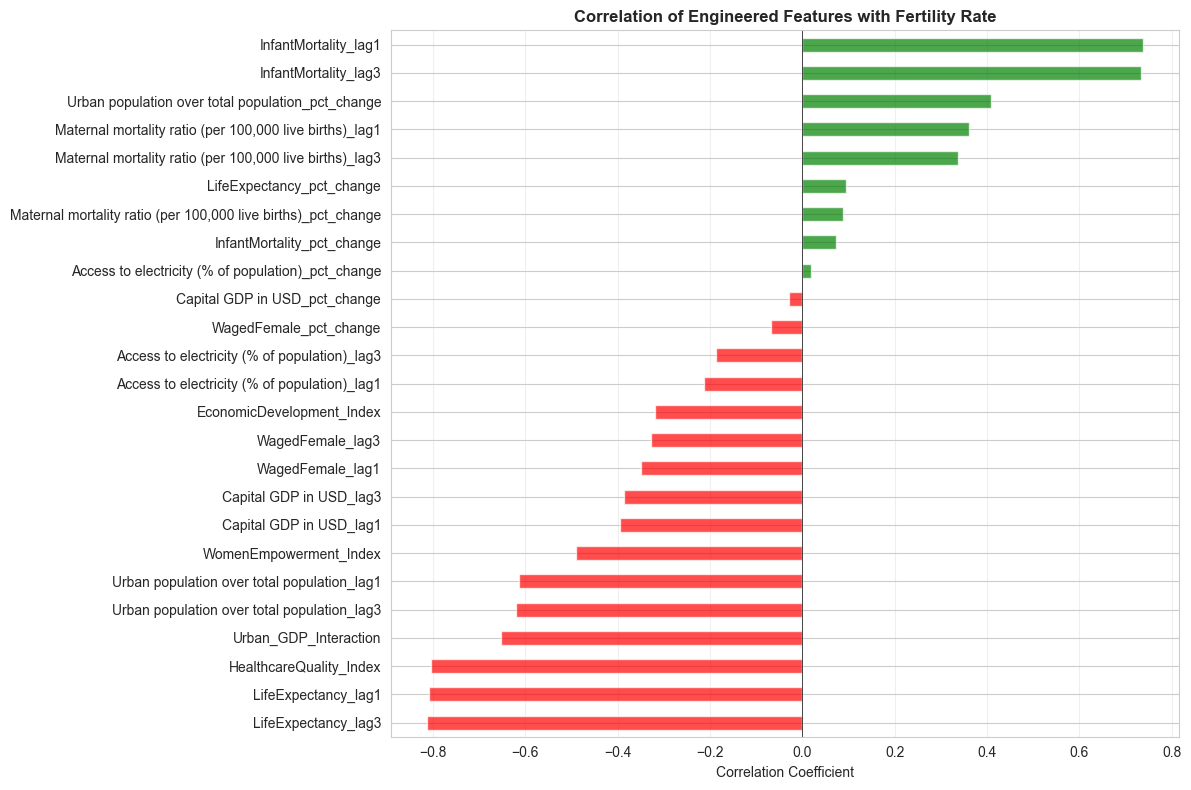

In [106]:
# Visualize correlations of new features
new_features = [col for col in df_final.columns if any(x in col for x in 
                ['_lag', '_pct_change', '_Index', '_Interaction'])]
new_features = [col for col in new_features if col in numeric_features]

if new_features:
    new_feature_corr = correlations[new_features].sort_values()
    
    plt.figure(figsize=(12, max(8, len(new_features) * 0.3)))
    colors = ['red' if x < 0 else 'green' for x in new_feature_corr.values]
    new_feature_corr.plot(kind='barh', color=colors, alpha=0.7)
    plt.xlabel('Correlation Coefficient')
    plt.title('Correlation of Engineered Features with Fertility Rate', fontsize=12, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Save Engineered Dataset

In [107]:
# Save the engineered dataset
output_path = '../data/clean/fertility_rate_engineered_features.csv'
df_final.to_csv(output_path, index=False)
print(f"Engineered dataset saved to: {output_path}")
print(f"Shape: {df_final.shape}")
print(f"\nReady for model building!")

Engineered dataset saved to: ../data/clean/fertility_rate_engineered_features.csv
Shape: (13205, 40)

Ready for model building!


In [108]:
# Display sample of final dataset
print("\nSample of final dataset:")
df_final.head(10)


Sample of final dataset:


,Country Name,Country Code,Year,"Maternal mortality ratio (per 100,000 live births)","Labor force participation rate, female (%)",Fertility rate,Urban population over total population,Capital GDP in USD,Access to electricity (% of population),WagedFemale,InfantMortality,LifeExpectancy,InfantMortality_lag1,InfantMortality_lag3,LifeExpectancy_lag1,LifeExpectancy_lag3,Access to electricity (% of population)_lag1,Access to electricity (% of population)_lag3,WagedFemale_lag1,WagedFemale_lag3,Urban population over total population_lag1,Urban population over total population_lag3,"Maternal mortality ratio (per 100,000 live births)_lag1","Maternal mortality ratio (per 100,000 live births)_lag3",Capital GDP in USD_lag1,Capital GDP in USD_lag3,InfantMortality_pct_change,LifeExpectancy_pct_change,Access to electricity (% of population)_pct_change,WagedFemale_pct_change,Urban population over total population_pct_change,"Maternal mortality ratio (per 100,000 live births)_pct_change",Capital GDP in USD_pct_change,HealthcareQuality_Index,EconomicDevelopment_Index,WomenEmpowerment_Index,Urban_GDP_Interaction,Decade,Era,Development_Level
3,Afghanistan,AFG,1963.000,71.000,62.850,7.302,9.276,2129.799,99.400,63.551,242.500,34.201,245.400,251.200,33.757,32.799,99.400,99.400,63.551,63.551,8.976,8.401,71.000,71.000,2129.799,2129.799,-1.182,1.315,0.000,0.000,3.342,0.000,0.000,0.120,0.501,0.632,71.094,1960,1960-1979,Lower Middle Income
4,Afghanistan,AFG,1964.000,71.000,62.850,7.304,9.586,2129.799,99.400,63.551,239.700,34.673,242.500,248.400,34.201,33.291,99.400,99.400,63.551,63.551,9.276,8.684,71.000,71.000,2129.799,2129.799,-1.155,1.380,0.000,0.000,3.342,0.000,0.000,0.129,0.501,0.632,73.470,1960,1960-1979,Lower Middle Income
5,Afghanistan,AFG,1965.000,71.000,62.850,7.305,9.904,2129.799,99.400,63.551,236.900,35.124,239.700,245.400,34.673,33.757,99.400,99.400,63.551,63.551,9.586,8.976,71.000,71.000,2129.799,2129.799,-1.168,1.301,0.000,0.000,3.317,0.000,0.000,0.138,0.501,0.632,75.907,1960,1960-1979,Lower Middle Income
6,Afghanistan,AFG,1966.000,71.000,62.850,7.320,10.233,2129.799,99.400,63.551,234.200,35.583,236.900,242.500,35.124,34.201,99.400,99.400,63.551,63.551,9.904,9.276,71.000,71.000,2129.799,2129.799,-1.140,1.307,0.000,0.000,3.322,0.000,0.000,0.147,0.501,0.632,78.428,1960,1960-1979,Lower Middle Income
7,Afghanistan,AFG,1967.000,71.000,62.850,7.339,10.570,2129.799,99.400,63.551,231.400,36.042,234.200,239.700,35.583,34.673,99.400,99.400,63.551,63.551,10.233,9.586,71.000,71.000,2129.799,2129.799,-1.196,1.290,0.000,0.000,3.293,0.000,0.000,0.156,0.501,0.632,81.011,1960,1960-1979,Lower Middle Income
8,Afghanistan,AFG,1968.000,71.000,62.850,7.363,10.918,2129.799,99.400,63.551,228.600,36.510,231.400,236.900,36.042,35.124,99.400,99.400,63.551,63.551,10.570,9.904,71.000,71.000,2129.799,2129.799,-1.210,1.298,0.000,0.000,3.292,0.000,0.000,0.165,0.501,0.632,83.678,1960,1960-1979,Lower Middle Income
9,Afghanistan,AFG,1969.000,71.000,62.850,7.389,11.275,2129.799,99.400,63.551,225.800,36.979,228.600,234.200,36.510,35.583,99.400,99.400,63.551,63.551,10.918,10.233,71.000,71.000,2129.799,2129.799,-1.225,1.285,0.000,0.000,3.270,0.000,0.000,0.175,0.501,0.632,86.414,1960,1960-1979,Lower Middle Income
10,Afghanistan,AFG,1970.000,71.000,62.850,7.400,11.643,2129.799,99.400,63.551,223.100,37.460,225.800,231.400,36.979,36.042,99.400,99.400,63.551,63.551,11.275,10.570,71.000,71.000,2129.799,2129.799,-1.196,1.301,0.000,0.000,3.264,0.000,0.000,0.184,0.501,0.632,89.235,1970,1960-1979,Lower Middle Income
11,Afghanistan,AFG,1971.000,71.000,62.850,7.432,12.021,2129.799,99.400,63.551,220.200,37.932,223.100,228.600,37.460,36.510,99.400,99.400,63.551,63.551,11.643,10.918,71.000,71.000,2129.799,2129.799,-1.300,1.260,0.000,0.000,3.247,0.000,0.000,0.193,0.501,0.632,92.132,1970,1960-1979,Lower Middle Income
12,Afghanistan,AFG,1972.000,71.000,62.850,7.453,12.410,2129.799,99.400,63.551,217.100,38.423,220.200,225.800,37.932,36.979,99.400,99.400,63.551,63.551,12.021,11.275,71.000,71.000,21

In [109]:
# Show data types
print("\nData types:")
print(df_final.dtypes)


Data types:
Country Name                                                      object
Country Code                                                      object
Year                                                             float64
Maternal mortality ratio (per 100,000 live births)               float64
Labor force participation rate, female (%)                       float64
Fertility rate                                                   float64
Urban population over total population                           float64
Capital GDP in USD                                               float64
Access to electricity (% of population)                          float64
WagedFemale                                                      float64
InfantMortality                                                  float64
LifeExpectancy                                                   float64
InfantMortality_lag1                                             float64
InfantMortality_lag3                  